In [101]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

# Generate time varying channel prob

In [103]:
def generate_time_varying_reliabilities(N, T, initial_reliabilities, volatility=0.01):
    """Generate time-varying reliability for each source using random walks"""
    # Generate ALL random steps at once: (N × T-1) matrix
    # Generate T-1 noises, that is first 1 0 1 0...
    # then subtract 0.5 from it, either 0.5 or -0.5, then multiply with the
    # volatility, so it becomes +0.01 or -0.01 something like this
    # the binomial generates with success prob of 0.5
    bernoulli_rvs = volatility * (np.random.binomial(1, 0.5, (N, T-1)) - 0.5)
    
    # Initialize trajectories
    p_trajectories = np.zeros((N, T)) # N sources X T time instances
    p_trajectories[:, 0] = initial_reliabilities
    
    # Cumulative sum gives the random walk!
    # cumsum([0.01, -0.01, 0.01]) = [0.01, 0.00, 0.01]
    # p(t) = p(t-1) + random_step (noise), previouse + noise = current
    # that is p(t) = p(0) + noise1 + noise2 + ... = p(0) + sum(noises)
    # we are now adding new dimension such that it has t time instances
    p_trajectories[:, 1:] = initial_reliabilities[:, np.newaxis] + np.cumsum(bernoulli_rvs, axis=1)
    
    # Enforce bounds [0.1, 1.0] for entire array at once
    p_trajectories = np.clip(p_trajectories, 0.1, 1.0)
    
    return p_trajectories

# Whittle index formula

In [105]:
def whittle_index_reliable(age, cost_function):
    """Reliable: W(h) = h*f(h+1) - Σf(j)"""
    h = age
    term1 = h * cost_function(h + 1)
    term2 = np.sum(cost_function(np.arange(1, h + 1)))
    return term1 - term2

def whittle_index_unreliable(age, cost_func, reliability, max_k=200):
    """Unreliable: W(h) = p²h·Σf(k+h)·(1-p)^(k-1) - p·Σf(j)"""
    h = age
    p = reliability
    
    # k goes to infinity, so cap it to around max_k
    k_vals = np.arange(1, max_k + 1)
    j_vals = np.arange(1, h + 1)
    
    term1 = (p**2) * h * np.sum(cost_func(k_vals + h) * (1 - p)**(k_vals - 1))
    term2 = p * np.sum(cost_func(j_vals))
    
    return term1 - term2

# Simulation function

In [107]:
def sim_time_varying(policy, funcs, true_reliabilities, T=3000, alpha=0.1, weights=None):
    """
    Simulate with time-varying reliabilities
    
    Args:
        policy: 'W_true' (knows true p), 'W_est' (estimates p with EMA), 'MW', 'GA', 'RR'
        funcs: List of cost functions
        true_reliabilities: (N x T) array of true time-varying reliabilities
        alpha: Learning rate for EMA estimator
        weights: Weights for MaxWeight policy
    """
    N = len(funcs)
    ages = np.ones(N, dtype=int) # N sources, all of them start with 1
    cost = 0
    
    # Initialize estimator
    if policy == 'W_est':
        p_estimate = true_reliabilities[:, 0].copy()  # Shape: (N,), Start with initial value
    
    for t in range(T):
        # Accumulate cost
        cost += sum(funcs[i](ages[i]) for i in range(N))
        
        # Select source based on policy
        if policy == 'W_true':
            # Use true reliability at time t
            sel = np.argmax([whittle_index_unreliable(ages[i], funcs[i], true_reliabilities[i, t]) 
                           for i in range(N)])
        
        elif policy == 'W_est':
            # Use estimated reliability
            sel = np.argmax([whittle_index_unreliable(ages[i], funcs[i], p_estimate[i]) 
                           for i in range(N)])
        
        elif policy == 'MW':
            sel = np.argmax([weights[i] * ages[i] * (ages[i] + 2) for i in range(N)])
        
        elif policy == 'GA':
            sel = np.argmax(ages)
        
        elif policy == 'RR':
            sel = t % N
        
        # Transmission outcome (Bernoulli with true reliability at time t)
        transmission_success = np.random.rand() < true_reliabilities[sel, t]
        
        # Update estimator (EMA) if using estimated policy
        if policy == 'W_est':
            # Exponential moving average update
            p_estimate[sel] = (1 - alpha) * p_estimate[sel] + alpha * transmission_success
        
        # Update ages
        ages += 1  # Age everyone by 1
        if transmission_success: #else it wont update
            ages[sel] = 1  # Reset selected source
    
    return cost / T

# Experiment

In [109]:
N_vals = [2, 5, 10, 15, 20, 30]
W_true_costs, W_est_costs, MW_costs, GA_costs, RR_costs = [], [], [], [], []

np.random.seed(42)  # For reproducibility

for N in N_vals:
    print(f"\nRunning N={N}...")
    
    # Cost functions (MOD 4 pattern)
    funcs = [lambda x, i=i: [x**3, np.minimum(np.exp(x), 1e10), 15*x, x**2][i%4]
             for i in range(N)]

    # Simple linear cost: f(x) = x
    #funcs = [lambda x: x for i in range(N)]
    
    # Initial reliabilities,from the paper
    initial_reliabilities = np.array([0.8, 0.85, 0.75, 0.66] * (N // 4) + 
                                     [0.8, 0.85, 0.75, 0.66][:N % 4])
    
    # Weights, from the paper
    weights = np.array([100, 1000, 15, 50] * (N // 4) + [100, 1000, 15, 50][:N % 4])
    
    # Generate time-varying reliabilities
    T = 3000
    alpha = 0.01
    volatility = 0.005
    true_reliabilities = generate_time_varying_reliabilities(N, T, initial_reliabilities, volatility=volatility)
    
    # Run simulations
    W_true_costs.append(sim_time_varying('W_true', funcs, true_reliabilities, T=T))
    W_est_costs.append(sim_time_varying('W_est', funcs, true_reliabilities, T=T, alpha= alpha))
    MW_costs.append(sim_time_varying('MW', funcs, true_reliabilities, T=T, weights=weights))
    GA_costs.append(sim_time_varying('GA', funcs, true_reliabilities, T=T))
    RR_costs.append(sim_time_varying('RR', funcs, true_reliabilities, T=T))
    
    print(f"N={N:2d} | Whittle (True p): {W_true_costs[-1]:7.2f} | "
          f"Whittle (Est p): {W_est_costs[-1]:7.2f} | "
          f"MaxWeight: {MW_costs[-1]:7.2f} | "
          f"Greedy: {GA_costs[-1]:7.2f} | "
          f"RR: {RR_costs[-1]:7.2f}")


Running N=2...
N= 2 | Whittle (True p):   20.48 | Whittle (Est p):   25.20 | MaxWeight:   88.31 | Greedy:   22.73 | RR:   83.74

Running N=5...
N= 5 | Whittle (True p):  331.20 | Whittle (Est p):  316.76 | MaxWeight:  652.84 | Greedy: 1299.07 | RR: 537072.83

Running N=10...
N=10 | Whittle (True p): 3857.52 | Whittle (Est p): 3741.54 | MaxWeight: 6991.37 | Greedy: 56902316.50 | RR: 578690417.41

Running N=15...
N=15 | Whittle (True p): 17219.69 | Whittle (Est p): 16079.94 | MaxWeight: 28628.60 | Greedy: 740908126.24 | RR: 3062205173.71

Running N=20...
N=20 | Whittle (True p): 56296.81 | Whittle (Est p): 58945.98 | MaxWeight: 129005.25 | Greedy: 9579747706.72 | RR: 6630528466.09

Running N=30...


C:\Users\kc11m\AppData\Local\Temp\ipykernel_28036\4027934035.py:10: RuntimeWarning: overflow encountered in exp
  funcs = [lambda x, i=i: [x**3, np.minimum(np.exp(x), 1e10), 15*x, x**2][i%4]


N=30 | Whittle (True p): 1951997.48 | Whittle (Est p): 1329848.66 | MaxWeight: 110716332.03 | Greedy: 37209986419.04 | RR: 31888672221.33


# Plotting

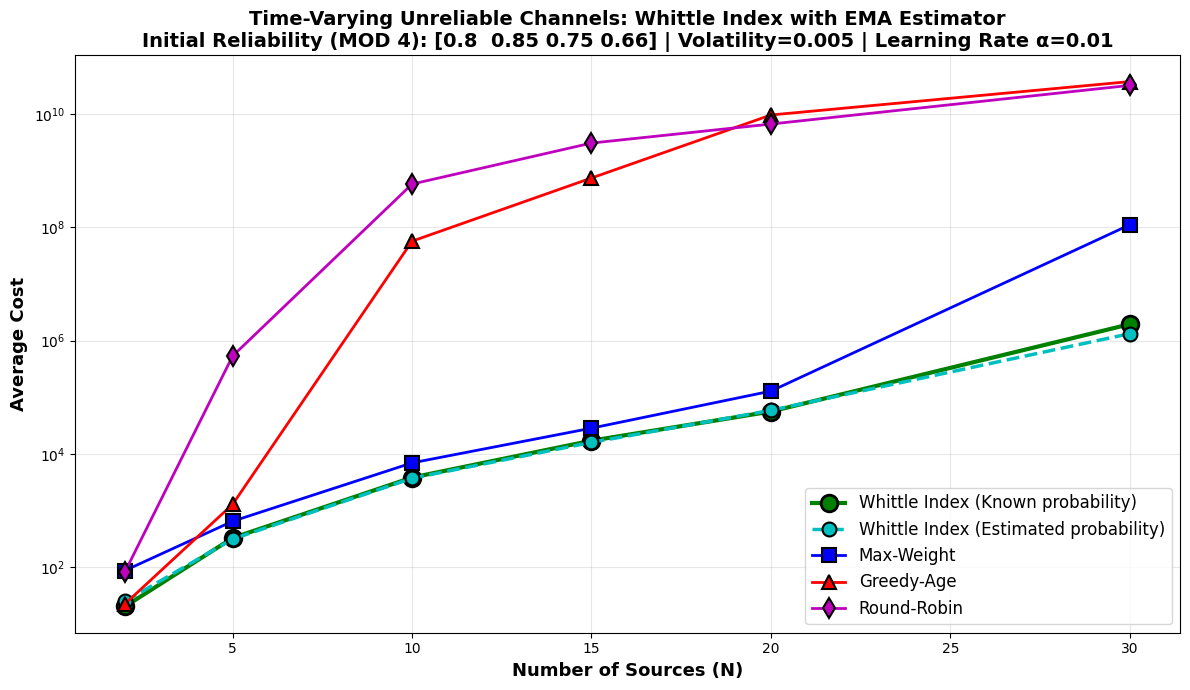


Done! Time-varying reliability simulation with EMA estimator complete.


In [111]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, W_true_costs, 'go-', lw=3, ms=12, markeredgecolor='black',
         markeredgewidth=2, label='Whittle Index (Known probability)')
plt.plot(N_vals, W_est_costs, 'co--', lw=2.5, ms=10, markeredgecolor='black',
         markeredgewidth=1.5, label='Whittle Index (Estimated probability)')
plt.plot(N_vals, MW_costs, 'bs-', lw=2, ms=10, markeredgecolor='black',
         markeredgewidth=1.5, label='Max-Weight')
plt.plot(N_vals, GA_costs, 'r^-', lw=2, ms=10, markeredgecolor='black',
         markeredgewidth=1.5, label='Greedy-Age')
plt.plot(N_vals, RR_costs, 'md-', lw=2, ms=10, markeredgecolor='black',
         markeredgewidth=1.5, label='Round-Robin')

plt.xlabel('Number of Sources (N)', fontsize=13, fontweight='bold')
plt.ylabel('Average Cost', fontsize=13, fontweight='bold')
plt.title(f'Time-Varying Unreliable Channels: Whittle Index with EMA Estimator\n'
          f'Initial Reliability (MOD 4): {initial_reliabilities[:4]} | '
          f'Volatility={volatility} | Learning Rate α={alpha}',
          fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

print("\nDone! Time-varying reliability simulation with EMA estimator complete.")

# Varying Probability and Estimation

In [124]:
# Generate time-varying reliabilities
N = 4
T = 3000
alpha = 0.01
volatility = 0.005
initial_reliabilities = np.array([0.8, 0.85, 0.75, 0.66])
true_reliabilities = generate_time_varying_reliabilities(N, T, initial_reliabilities, volatility=volatility)

print("True reliabilities shape:", true_reliabilities.shape)  # (4, 3000)

t = T-1  # or any specific time
transmission_success_single = (np.random.rand(N) < true_reliabilities[:, t]).astype(int)
print("\nSingle time step transmission:", transmission_success_single.shape)  # (4,)
print(transmission_success_single)  # [1 1 1 0]

transmission_success_all = (np.random.rand(N, T) < true_reliabilities).astype(int)
print("\nAll time steps transmission:", transmission_success_all.shape)  # (4, 3000)
print("First 10 time steps:\n", transmission_success_all[:, :10])

p_estimate = np.zeros((N, T))
p_estimate[:, 0] = initial_reliabilities  # Start with true estimate

for t in range(1, T):
    # Update estimates based on transmission outcomes
    p_estimate[:, t] = (1 - alpha) * p_estimate[:, t-1] + alpha * transmission_success_all[:, t]

print(p_estimate)

True reliabilities shape: (4, 3000)

Single time step transmission: (4,)
[1 1 0 1]

All time steps transmission: (4, 3000)
First 10 time steps:
 [[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 0 1 0 0 0]
 [1 1 0 1 1 1 1 1 1 0]
 [0 1 1 0 0 1 0 1 1 1]]
[[0.8        0.802      0.80398    ... 0.92983077 0.93053246 0.93122713]
 [0.85       0.8515     0.852985   ... 0.8503341  0.85183075 0.84331245]
 [0.75       0.7525     0.744975   ... 0.55257095 0.55704524 0.56147479]
 [0.66       0.6634     0.666766   ... 0.69536478 0.69841113 0.70142702]]


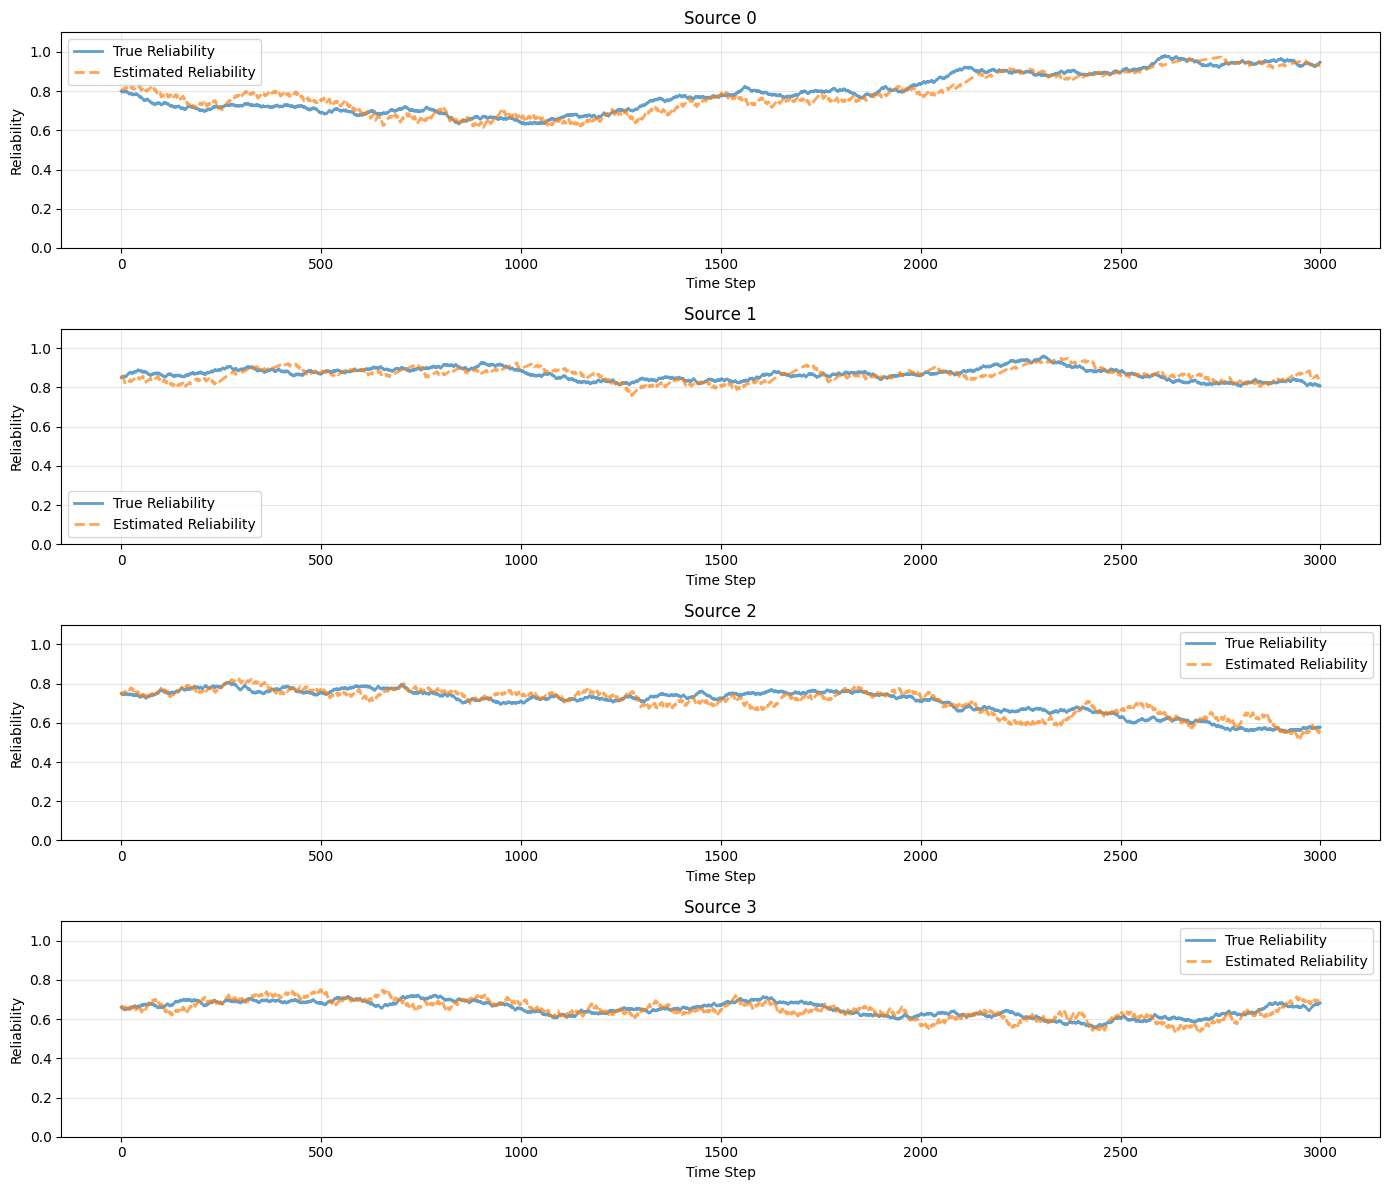


Mean Absolute Error per source:
Source 0: 0.0297
Source 1: 0.0230
Source 2: 0.0275
Source 3: 0.0248


In [126]:
# Plot true vs estimated reliabilities
fig, axes = plt.subplots(N, 1, figsize=(14, 3*N))
if N == 1:
    axes = [axes]

for i in range(N):
    axes[i].plot(range(T), true_reliabilities[i, :], 
                 label='True Reliability', linewidth=2, alpha=0.7)
    axes[i].plot(range(T), p_estimate[i, :], 
                 label='Estimated Reliability', linewidth=2, alpha=0.7, linestyle='--')
    
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Reliability')
    axes[i].set_title(f'Source {i}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Print tracking performance
mae = np.mean(np.abs(true_reliabilities - p_estimate), axis=1)
print("\nMean Absolute Error per source:")
for i in range(N):
    print(f"Source {i}: {mae[i]:.4f}")